# Классификация картин

In [1]:
%matplotlib inline

import os
import warnings
warnings.filterwarnings("ignore")

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as M
from copy import copy
from sklearn import model_selection
from tqdm import tqdm

print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 32

2.1.2
0.16.2


## Данные для классификации

В качестве данных возьмем датасет [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time/) на платформе Kaggle.

In [2]:
# Подгрузим метаданные
artists_df = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')
artists_df.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

In [3]:
# Путь к директории
dir_path = '/kaggle/input/artists/artists'

# Получение списка файлов и директорий в указанной директории
content = os.listdir(dir_path)

print(f'Число художников в датасете: {len(content)} ')

Число художников в датасете: 50 


Сколько всего представлено произведений искусства в датасете:

In [4]:
# Получаем список всех подпапок в родительской папке
subfolders = [f.path for f in os.scandir(dir_path) if f.is_dir()]

# Проходим по каждой подпапке и считаем количество изображений
file_counter = 0
for folder in subfolders:
    for _, _, files in os.walk(folder):
        file_counter += len(files)

print(f'Всего имеется {file_counter} картин.')

Всего имеется 8446 картин.


Итак, для обучения у нас есть около 8,5 тысяч изображений и 50 классов.

Для обучения на этих данных нам нужно получить объекты класса `Dataset` для дальнейшей работы с ними.

Воспользуемся готовым классом `ImageFolder`, который как раз работает с директориями такого вида.

Cоздадим объект датасета по всем изображениям и изучим его:

In [5]:
artists_dataset = torchvision.datasets.ImageFolder(dir_path)

artists_dataset.classes[artists_dataset[0][1]]

'Albrecht_Durer'

При выводе видим, что метка класса 1 соответствует художнику Альбрехту Дюреру.

Как выглядит само изображение?

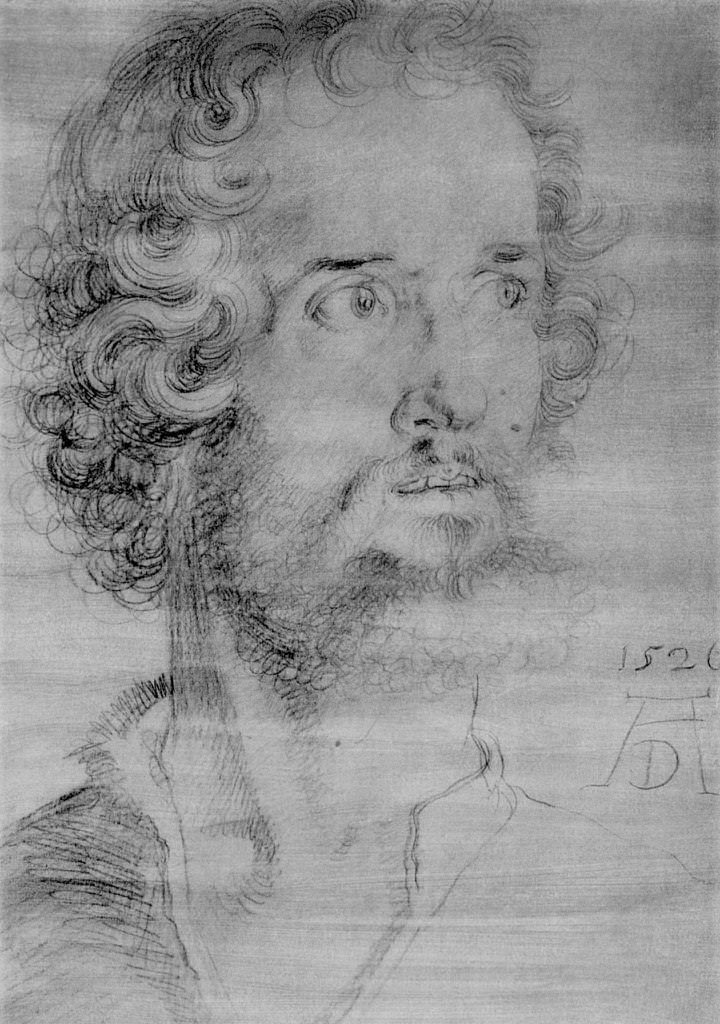

In [6]:
artists_dataset[0][0]

Рассмотрим и другие примеры. Для этого реализуем промежуточную функцию plot_samples, в которую передадим датасет и укажем, сколько примеров отобразить. Создадим нужное количество графиков и на каждом из них выберем случайное изображение и случайный класс, то есть случайный семпл из датасета. Далее отобразим результат на соответствующем подграфике.

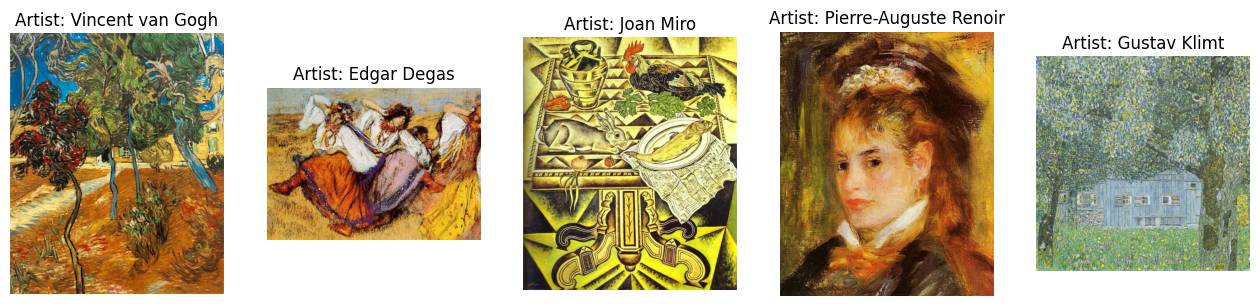

In [7]:
def plot_samples(dataset, num_samples=5):
    _, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(artists_dataset)

## Подготовка обучения и валидации

Для обучения "как по учебнику" нам нужно разбить имеющиеся данные на обучение и валидацию.

Воспользуемся функцией разбиения с учетом пропорций классов из библиотеки `scikit-learn` и выделим 1000 сэмплов для валидации:

In [8]:
sss = model_selection.StratifiedShuffleSplit(
    n_splits=1, test_size=1000, train_size=None, random_state=2024
)

Разделим сэмплы на пути и метки:

In [9]:
X = [x[0] for x in artists_dataset.samples]
y = [x[1] for x in artists_dataset.samples]

Получим индексы для обучения и валидации:

In [10]:
train_idx, valid_idx = list(sss.split(X, y))[0]

print(len(train_idx), len(valid_idx))

7446 1000


Теперь создадим копии объекта (которые будут знать про структуру датасета и его классы) для наших сплитов:

In [11]:
train_dataset = copy(artists_dataset)
train_dataset.samples = [artists_dataset.samples[i] for i in train_idx]
train_dataset.targets = [artists_dataset.targets[i] for i in train_idx]
train_dataset.imgs = train_dataset.samples

valid_dataset = copy(artists_dataset)
valid_dataset.samples = [artists_dataset.samples[i] for i in valid_idx]
valid_dataset.targets = [artists_dataset.targets[i] for i in valid_idx]
valid_dataset.imgs = valid_dataset.samples

print(len(train_dataset), len(valid_dataset))

7446 1000


Посмотрим на примеры из обучения и валидации:

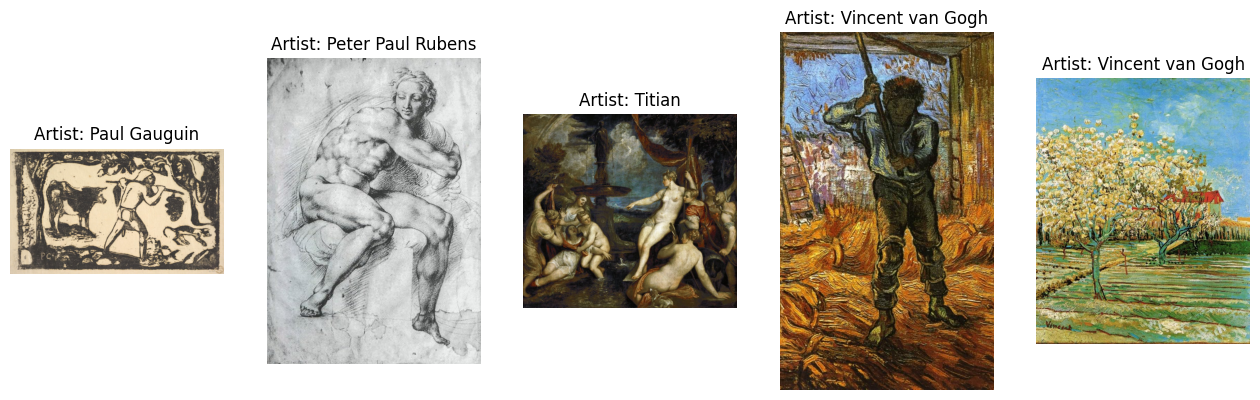

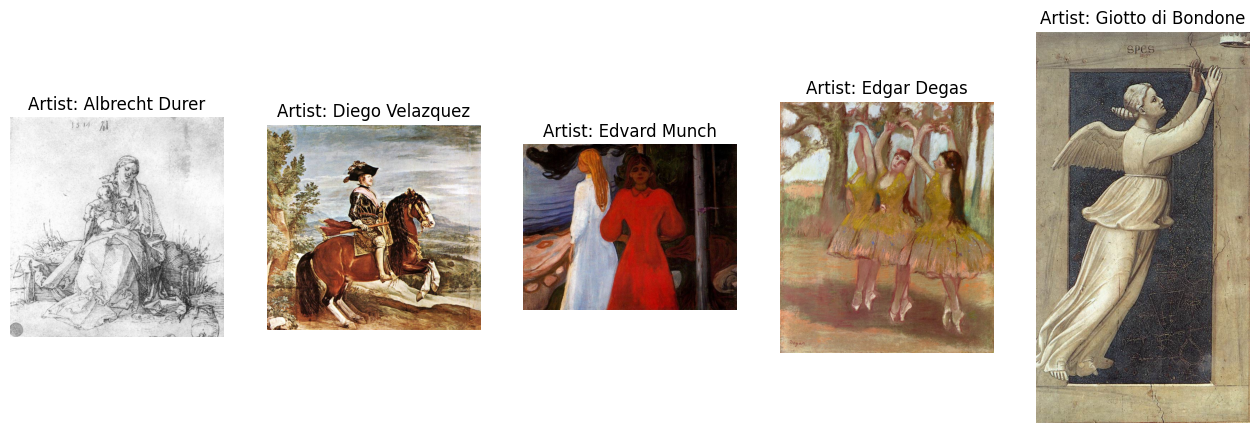

In [12]:
plot_samples(train_dataset)
plot_samples(valid_dataset)

Для того, чтобы использовать эти датасеты в процессе обучения, применим к ним стандартный препроцессинг:

In [13]:
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_dataset.transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])
valid_dataset.transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize
])

И обернуть в даталоадеры:

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=os.cpu_count()
)

## Обучение модели

Для обучение возьмем легковесную из семейства ResNet модель ResNet-34:

In [15]:
model = M.resnet34()

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

model.fc

Total parameters:  21797672


Linear(in_features=512, out_features=1000, bias=True)

Заметим, что полносвязный слой сети рассчитан на 1000 классов

Поэтому мы заменим его на полносвязный слой с нужным количеством классов:

In [16]:
model.fc = torch.nn.Linear(512, len(train_dataset.classes))

criterion = torch.nn.CrossEntropyLoss()

Функция потерь для обучения классификации — кроссэнтропия

Если доступен графический ускоритель, используем его:

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

В качестве оптимизатора используем Adam с параметрами по умолчанию для обучения ResNet.

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

Обернем процесс обучения в одну функцию:

In [19]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in tqdm(range(num_epochs)):
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for images, target in train_loader:
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []

        for images, target in valid_loader:
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

Обучим модель, построенную с нуля, в течение 10 эпох:

In [20]:
loss_train, top1_train, loss_valid, top1_valid = train_model(
    model, optimizer, train_dataset, valid_dataset, 10
)

100%|██████████| 10/10 [07:52<00:00, 47.29s/it]


## Анализ обученной модели

Как изменяются функция потерь и точность классификации?

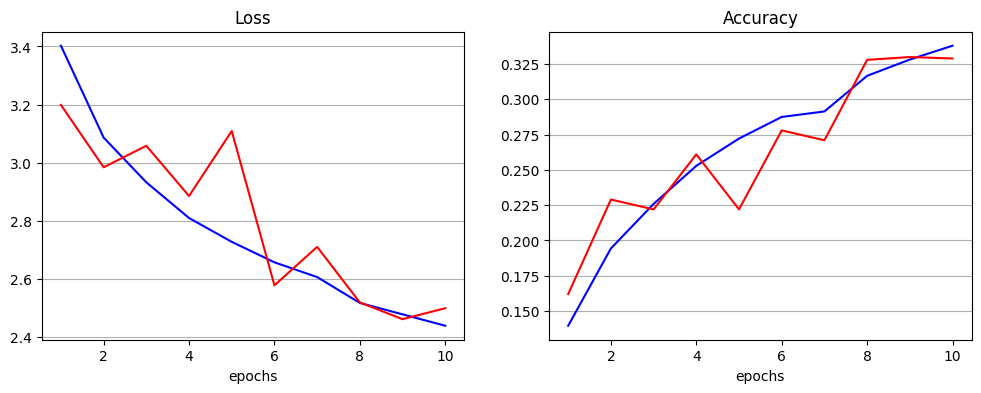

In [21]:
def get_plot():
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
    plt.xlabel("epochs")
    plt.title("Loss")
    plt.grid(axis='y')
    plt.subplot(122)
    plt.plot(range(1, len(top1_train) + 1), top1_train, color="b")
    plt.plot(range(1, len(top1_train) + 1), top1_valid, color="r")
    plt.xlabel("epochs")
    plt.title("Accuracy")
    plt.grid(axis='y')

    plt.show()

get_plot()    

Видим, что:

1) Точность растет и достигает значений лучше случайного предсказания (больше 30% при 50 классах);

2) На плато значений точности даже не начали выходить (после чего следовало бы уменьшить скорость обучения);

3) Точность похожая и на обучении, и при валидации, т.е. модель не переобучена.

## Использование предобученных весов

Попробуем обучить такую же модель, но начав с обученных на ImageNet весов:

In [22]:
model = M.resnet34(pretrained=True)
model.fc = torch.nn.Linear(512, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(), lr=1e-3, weight_decay=1e-4
)

loss_train, top1_train, loss_valid, top1_valid = train_model(
    model, optimizer, train_dataset, valid_dataset, 10
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 165MB/s] 
100%|██████████| 10/10 [07:41<00:00, 46.12s/it]


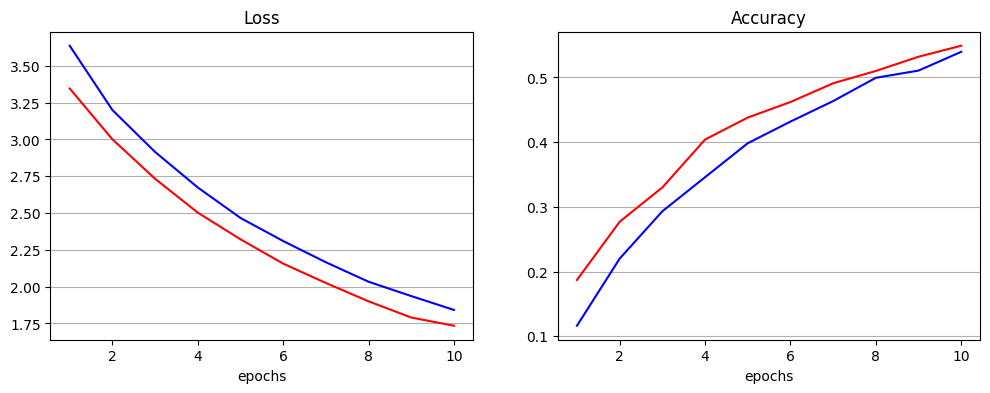

In [23]:
get_plot()

В данном случае модель достигла еще более высоких показателей точности за то же количество шагов обучения!

Отсюда следует сделать вывод, что использование готовых весов для старта позволяет добиться лучшего качества.

## Заморозка слоев и файн-тюнинг модели

Мы только что смогли обучить нейросетевую модель до приемлемого качества как с нуля, так и начиная с готовых весов.

Тем не менее в обоих случаях мы обновляли много миллионнов параметры, которые уже обучались на датасете с более чем 1.2 миллионами изображений и 1000 классами. А мы знаем, что на первых слоях сверточных сетей находятся нейроны, реагирующие на какие-то базовые признаки и паттерны. Обучать их вновь на нашем небольшом датасете со всего лишь десятками тысяч изображений, скорее всего, не лучшее решение.

Для того чтобы избежать обновления части весов, их можно "заморозить" — при обучении параметры этих слоев не будут меняться. Крайним случаем заморозки весов является заморозка всей модели, кроме финального полносвязного слоя.

Обучение лишь полносвязного слоя (он обычно пересоздается как мы это уже делали) часто называют файн-тюнингом модели (fine tuning). А в целом обучение модели для новой задачи, используя предобученные веса, называется transfer learning.

Как реализовать заморозку и файн-тюнинг силами pytorch?

У каждого нейросетевого модуля (`model.parameters()`) есть параметр `requires_grad`.

По умолчанию они все выставлены в `requires_grad=True` и тем самым "разморожены".

Как заморозить часть модели ResNet?

In [24]:
model = M.resnet34(pretrained=True)
for module in [model.conv1, model.bn1, model.layer1, model.layer2]:
    for parameter in module.parameters():
        parameter.requres_grad = False

В этом примере мы заморозили все начальные слои и два из четырех крупных блока сети.

Это может быть полезно, когда данных много, но не настолько, чтобы обучать всю сеть целиком (около ста тысяч как пример).

Как реализовать файн-тюнинг? Можно заморозить все слои по очереди, а можно и проще — заморозить сеть, а уже потом пересоздать FC-слой:

In [25]:
model = M.resnet34(pretrained=True)
for parameter in model.parameters():
    parameter.requres_grad = False
model.fc = torch.nn.Linear(512, len(train_dataset.classes))
model = model.to(device)

А теперь обучим сеть файн-тюнингом, что может быть значительно быстрее (обновляется ведь только последний слой):

In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(
    model, optimizer, train_dataset, valid_dataset, 30
)

100%|██████████| 30/30 [22:41<00:00, 45.38s/it]


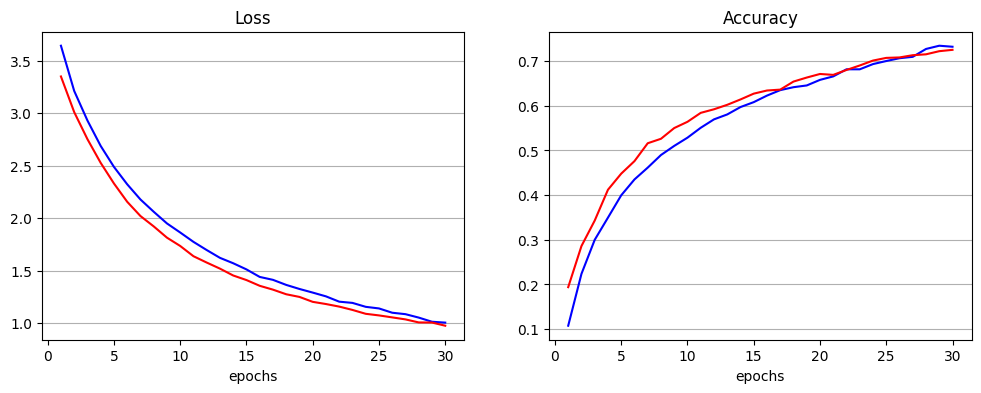

In [27]:
get_plot()

Обучение, как видим, можно было и продолжить, т.к. лоссы продолжают падать, а точность еще не вышла на плато. Но даже 70% точность угадывания автора картины, полагаю, уже намного опережает в разборчивости среднего посетителя выстовок.

## Предсказание построенной моделью

Загрузим фото с интерактивной выставки Ван Гога (это даже не сама картина)

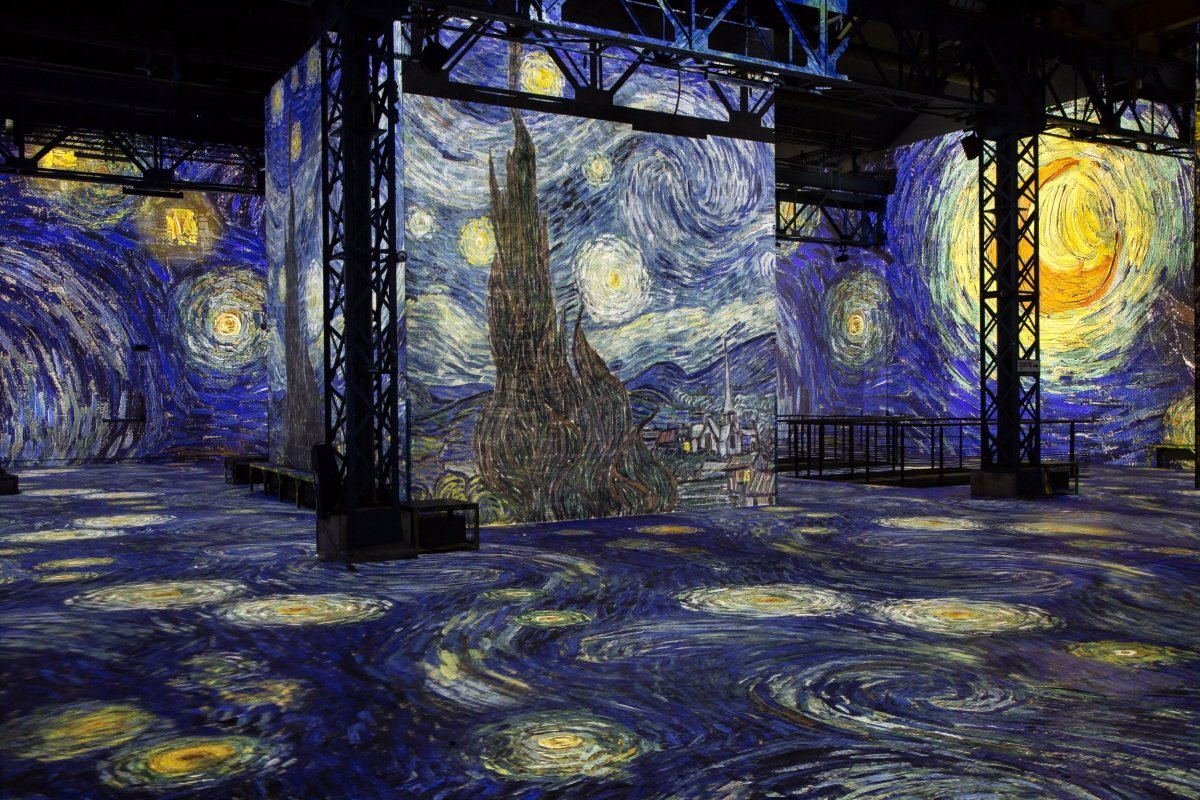

In [28]:
from PIL import Image
from skimage.io import imread, imshow

image = imread('https://mumabroad.com/wp-content/uploads/2020/06/z-Atelier-des-Lumieres.jpg')
PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
PIL_image

Собираем батч и делаем предсказание:

In [29]:
tensor = valid_dataset.transform(PIL_image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = model(batch.to(device)).to("cpu")
predicted = output.argmax().item()

И кто же это?

In [30]:
train_dataset.classes[predicted]

'Vincent_van_Gogh'

Работает!